In [130]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import datetime as dt
import hvplot.pandas
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit


In [90]:
# Reading in the provided CSV file into a pandas DataFrame
df = pd.read_csv("C:/Users/perry/OneDrive/Desktop/MyRepos/project4-team1/data files/Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv")

# Display the first few rows of the DataFrame to ensure it's loaded correctly
df.head()


,RegionID,SizeRank,RegionName,RegionType,StateName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,...,2022-10-31,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31,2023-06-30,2023-07-31
0,102001,0,United States,country,NaN,115215.060987,115417.693632,115668.835076,116207.361953,116827.017306,...,342893.791055,342019.278670,340897.172975,340243.409003,340186.438102,341377.341047,342529.876118,344118.510057,346019.054142,348126.180542
1,394913,1,"New York, NY",msa,NY,188937.406428,189741.459747,190551.713646,192192.721840,193888.790935,...,599230.535882,597398.651335,594922.993370,594887.333828,596112.580353,600050.039046,603155.817763,607323.863650,612506.387816,618653.073765
2,753899,2,"Los Angeles, CA",msa,CA,223645.274156,224472.515292,225577.803520,227796.103768,230229.751861,...,901388.388599,897672.540460,893323.330406,884961.557044,874796.651896,867473.497311,865273.506397,868900.838953,876737.860960,889296.983779
3,394463,3,"Chicago, IL",msa,IL,144553.677041,144690.734658,144948.658674,145591.296092,146362.956233,...,295984.602121,295278.942974,294593.348603,295177.666600,296265.508630,298199.210375,299544.045369,301304.103648,303807.012258,306516.933358
4,394514,4,"Dallas, TX",msa,TX,129710.334780,129775.242966,129848.594994,130032.097809,130266.530240,...,380982.324430,379062.994766,376514.698150,373917.253527,371811.542961,371082.877106,370740.713883,371147.729712,372189.451235,373555.542026


In [91]:
# List of cities to filter
cities = ["Austin, TX", "El Paso, TX", "Dallas, TX", "Houston, TX", "San Antonio, TX"]

# Filter for the cities of interest
selected_cities_df = df[df['RegionName'].isin(cities)]

# Convert the dataframe to have dates as rows and cities as columns
melted_df = selected_cities_df.melt(id_vars=["RegionName"], 
                                    value_vars=selected_cities_df.columns[7:], 
                                    var_name="Date", 
                                    value_name="ZHVI")

# Convert the 'Date' column to datetime type
melted_df['Date'] = pd.to_datetime(melted_df['Date'])

# Pivot the dataframe to have dates as the index and cities as columns
pivot_df = melted_df.pivot(index='Date', columns='RegionName', values='ZHVI')

# Display the first few rows of the processed dataframe
pivot_df.head()

RegionName,"Austin, TX","Dallas, TX","El Paso, TX","Houston, TX","San Antonio, TX"
Date,,,,,
2000-03-31,171884.569134,129848.594994,93406.463524,117792.538671,108402.254879
2000-04-30,172693.585774,130032.097809,93442.396478,117837.439149,108551.915169
2000-05-31,173303.117323,130266.530240,93487.924704,117880.213666,108064.245052
2000-06-30,173575.729427,130500.079302,93533.806108,118061.437933,107379.976616
2000-07-31,173682.480704,130744.571369,93540.520729,118239.445943,106617.696119


In [92]:
# Create a dictionary to hold dataframes for each unique RegionName
region_dfs = {}

# Split the melted_df based on unique RegionName values
for region in melted_df['RegionName'].unique():
    region_dfs[region] = melted_df[melted_df['RegionName'] == region].reset_index(drop=True)


In [94]:
Austin_df = region_dfs["Austin, TX"]
Austin_df.head()

,RegionName,Date,ZHVI
0,"Austin, TX",2000-03-31,171884.569134
1,"Austin, TX",2000-04-30,172693.585774
2,"Austin, TX",2000-05-31,173303.117323
3,"Austin, TX",2000-06-30,173575.729427
4,"Austin, TX",2000-07-31,173682.480704


In [95]:
Dallas_df = region_dfs["Dallas, TX"]
Dallas_df.head()

,RegionName,Date,ZHVI
0,"Dallas, TX",2000-03-31,129848.594994
1,"Dallas, TX",2000-04-30,130032.097809
2,"Dallas, TX",2000-05-31,130266.530240
3,"Dallas, TX",2000-06-30,130500.079302
4,"Dallas, TX",2000-07-31,130744.571369


In [96]:
San_Antonio_df = region_dfs["San Antonio, TX"]
San_Antonio_df.head()

,RegionName,Date,ZHVI
0,"San Antonio, TX",2000-03-31,108402.254879
1,"San Antonio, TX",2000-04-30,108551.915169
2,"San Antonio, TX",2000-05-31,108064.245052
3,"San Antonio, TX",2000-06-30,107379.976616
4,"San Antonio, TX",2000-07-31,106617.696119


In [97]:
El_Paso_df = region_dfs["El Paso, TX"]
El_Paso_df.head()

,RegionName,Date,ZHVI
0,"El Paso, TX",2000-03-31,93406.463524
1,"El Paso, TX",2000-04-30,93442.396478
2,"El Paso, TX",2000-05-31,93487.924704
3,"El Paso, TX",2000-06-30,93533.806108
4,"El Paso, TX",2000-07-31,93540.520729


In [99]:
#convert the "Date column to datetime format"
    # Raw date data 
Austin_df['Date'] = pd.to_datetime(Austin_df['Date'])
    # Date  data converted into an ordinal value 
Austin_df['ordinal_date'] = Austin_df['Date'].apply(lambda x: x.toordinal())
    # Index used as X value


# Split the data into training and testing sets

X = Austin_df['ordinal_date'].values.reshape(-1, 1)
y = Austin_df['ZHVI'].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [100]:
# Initialize and fit the data to the chosen model "IE Linear Regression"
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [101]:
# Create the predictions variable using .predict
predictions = model.predict(X_test)

# print both the predictions and y_test as refereence.
# print(X)

In [102]:
# Print Austin filtered data with the dates as the x value, and the ZHVI as the y value
Austin_Scatter = Austin_df.hvplot.scatter(
    x = 'Date',
    y = 'ZHVI')
Austin_Scatter


:Scatter   [Date]   (ZHVI)

In [103]:
# Display the slope
print(f"Model's slope: {model.coef_}")

# Display the y-intercept
print(f"Model's y-intercept: {model.intercept_}")

# Display the model's best fit line formula
print(f"Model's formula: y = {model.intercept_} + {model.coef_[0]}X")

Model's slope: [[15.43083826]]
Model's y-intercept: [-11109940.77249928]
Model's formula: y = [-11109940.77249928] + [15.43083826]X


In [104]:
# Display the formula to predict the salary for a person with 7 years of experience
print(f"Model's formula: y = {model.intercept_} + {model.coef_[0]} * 7")

# Predict the salary for a person with 7 years of experience
y_7 = model.intercept_ + model.coef_[0] * 736725

# Display the prediction
print(f"Predicted salary for a person with 7 years of experience: ${y_7}")

Model's formula: y = [-11109940.77249928] + [15.43083826] * 7
Predicted salary for a person with 7 years of experience: $[258343.54123052]


In [105]:
Austin_df['Predictions'] = model.intercept_ + model.coef_[0] * Austin_df['ordinal_date'].astype(int)
Austin_Linear = Austin_df.hvplot.line(x='Date', y='Predictions', color='Red')
Austin_Linear

:Curve   [Date]   (Predictions)

In [106]:
(Austin_Scatter*Austin_Linear)

:Overlay
   .Scatter.I :Scatter   [Date]   (ZHVI)
   .Curve.I   :Curve   [Date]   (Predictions)

## Random Forest

In [107]:
# # Splitting into Train and Test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

# # Creating StandardScaler instance
# scaler = StandardScaler()

# # Fitting Standard Scaller
# X_scaler = scaler.fit(X_train)

# # Scaling data
# X_train_scaled = X_scaler.transform(X_train)
# X_test_scaled = X_scaler.transform(X_test)

# # Create a random forest classifier
# rf_model = RandomForestRegressor(n_estimators=500, random_state=0)

# # Fitting the model
# rf_model = rf_model.fit(X_train_scaled, y_train)

## Random Forest attempt of calculating linear regression?

In [108]:
# # Display the formula to predict the salary for a person with 7 years of experience
# print(f"Model's formula: y = {rf_model.intercept_} + {model.coef_[0]} * 7")

# # Predict the salary for a person with 7 years of experience
# y_7 = rf_model.intercept_ + model.coef_[0] * 738510

# # Display the prediction
# print(f"Predictied price of a home in 2023-08-31: ${y_7}")

## List for future ZHVI Loop

In [109]:
# Refining the code using list comprehensions and direct DataFrame operations

# Starting date ordinal
current_date_ordinal = 738732

# Generate a list of dates incremented by one month for 60 iterations
dates_monthly_adjusted = [(dt.datetime.fromordinal(current_date_ordinal) + pd.DateOffset(months=i)).toordinal() 
                          for i in range(60)]

# Adjusting the calculation of predicted values to ensure scalar outputs
outputs_monthly_adjusted_scalar = [float(model.intercept_ + model.coef_[0] * date) for date in dates_monthly_adjusted]

# Create a DataFrame directly from the lists with scalar outputs
df_monthly_refined_scalar = pd.DataFrame({
    'Input_Date_Ordinal': dates_monthly_adjusted,
    'Predicted_Value': outputs_monthly_adjusted_scalar
})

# Convert the ordinal dates to DateTime format for better readability
df_monthly_refined_scalar['Input_Date'] = df_monthly_refined_scalar['Input_Date_Ordinal'].apply(dt.datetime.fromordinal)

df_monthly_refined_scalar.head()  # Display the first few rows of the refined DataFrame with scalar outputs



,Input_Date_Ordinal,Predicted_Value,Input_Date
0,738732,289313.233609,2023-07-31
1,738763,289791.589595,2023-08-31
2,738793,290254.514743,2023-09-30
3,738824,290732.870729,2023-10-31
4,738854,291195.795876,2023-11-30


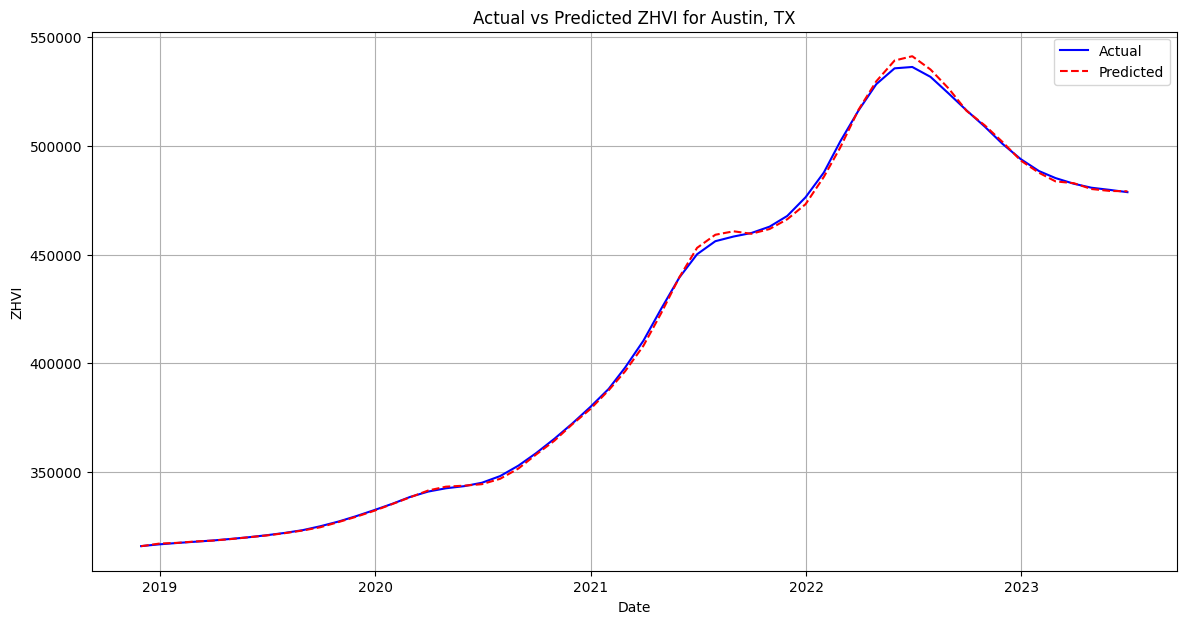

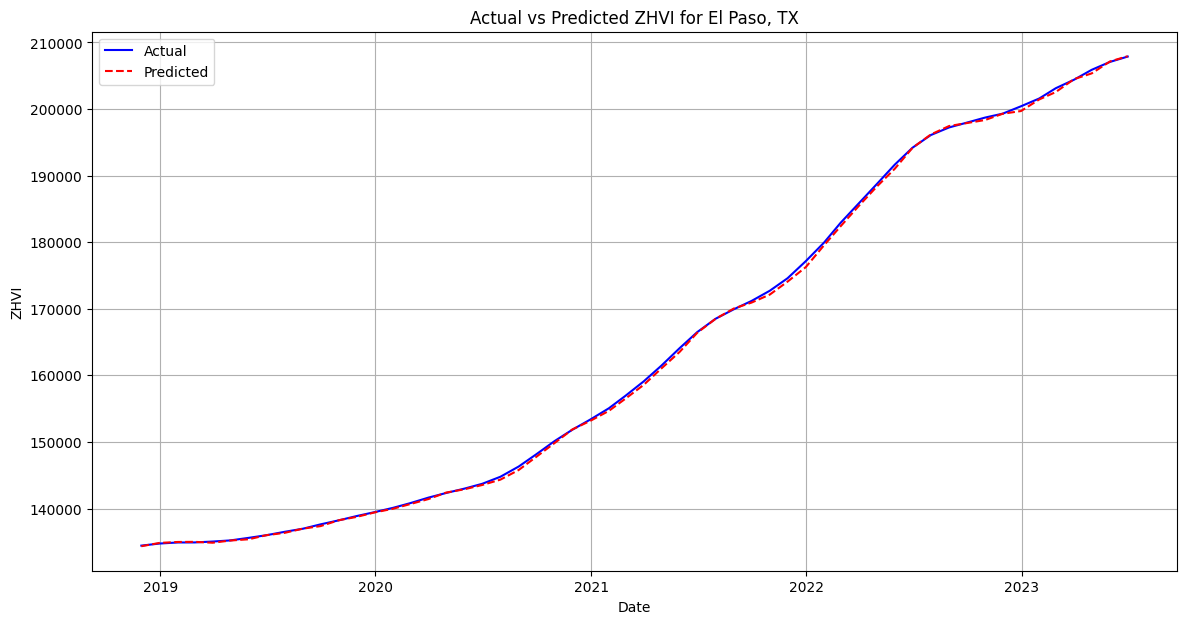

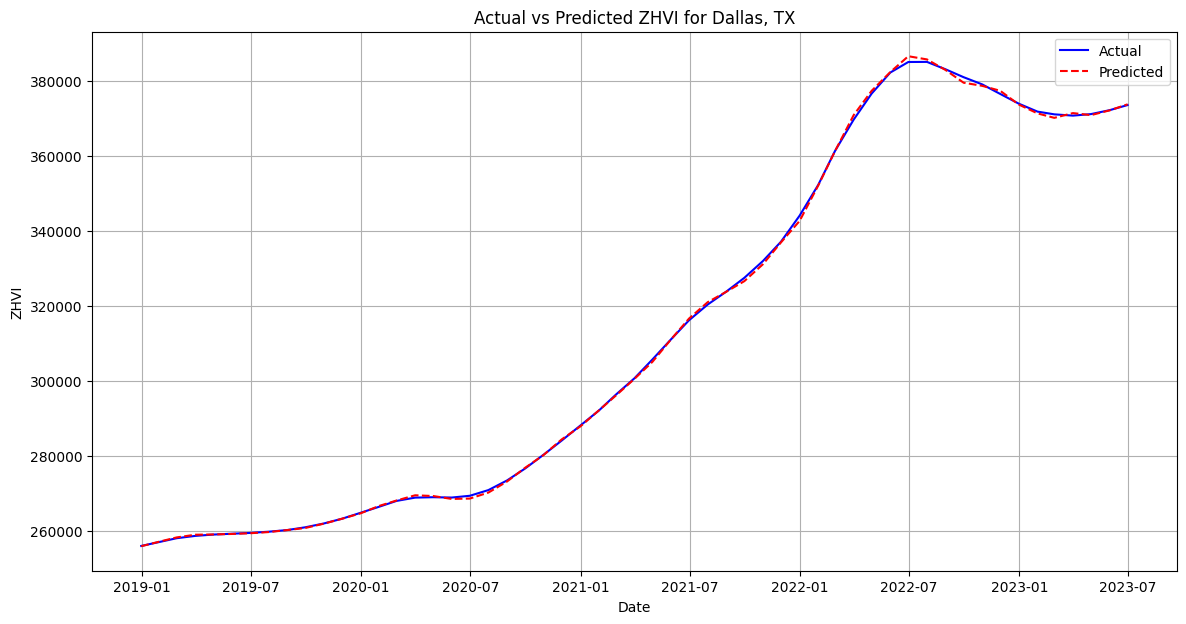

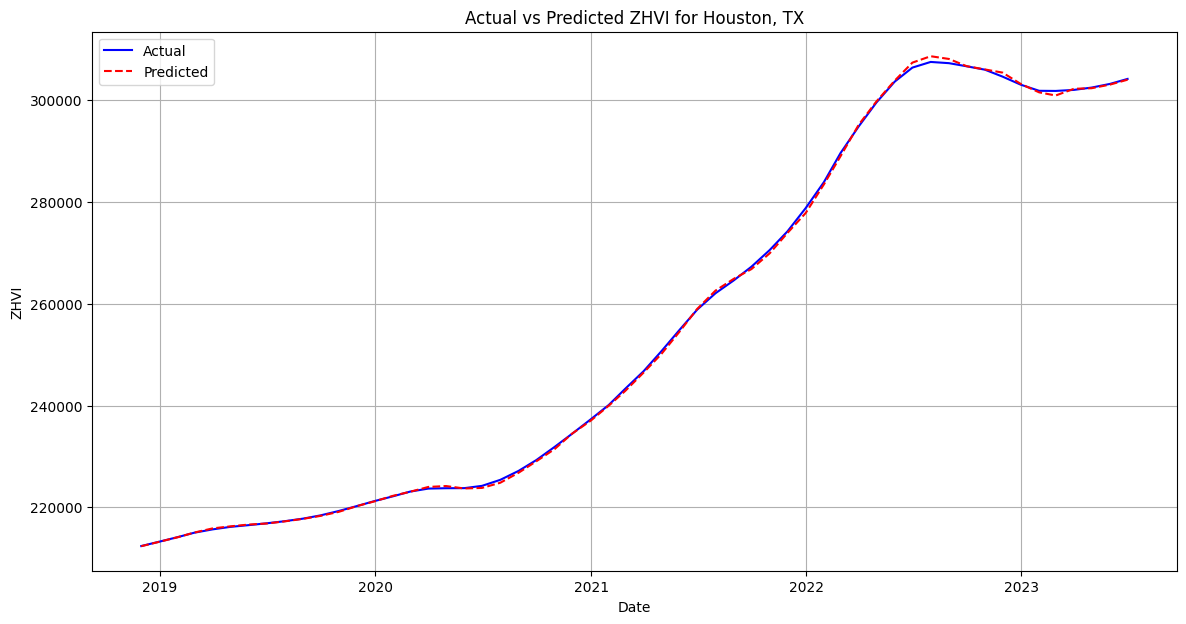

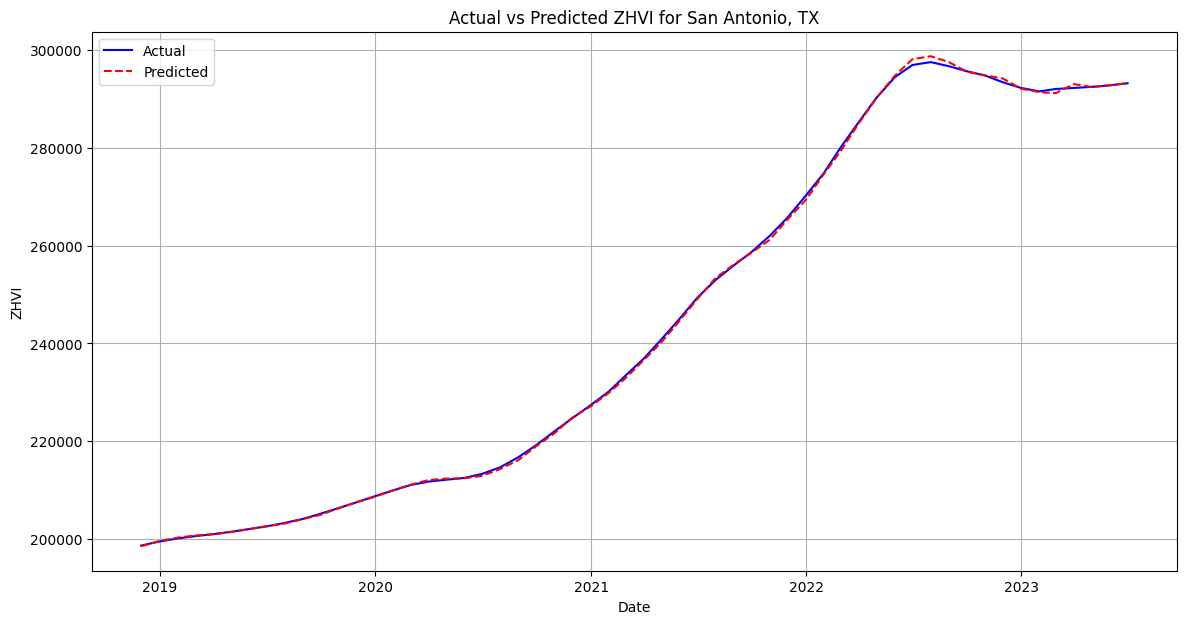

Austin, TX: R-squared = 1.00
El Paso, TX: R-squared = 1.00
Dallas, TX: R-squared = 1.00
Houston, TX: R-squared = 1.00
San Antonio, TX: R-squared = 1.00


In [126]:
# List of cities we are interested in
cities = ["Austin, TX", "El Paso, TX", "Dallas, TX", "Houston, TX", "San Antonio, TX"]

# Dictionary to store models and predictions for each city
models = {}
predictions = {}
r2_scores = {}

# Loop through each city
for city in cities:
    # Process the data for the current city
    city_data = pivot_df[[city]].copy()

    # Create lagged features
    city_data["Lag_1"] = city_data[city].shift(1)
    city_data["Lag_2"] = city_data[city].shift(2)
    city_data["Lag_3"] = city_data[city].shift(3)

    # Drop rows with NaN values (due to lagged features)
    city_data = city_data.dropna()

    # Features and target variable
    X = city_data[[city, "Lag_1", "Lag_2", "Lag_3"]]
    y = city_data[city].shift(-1)  # We are predicting the next month's value

    # Split the data into training and testing sets (80-20 split)
    X_train, X_test, y_train, y_test = train_test_split(X[:-1], y.dropna(), test_size=0.2, shuffle=False)

    # Train the Linear Regression model for the current city
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Store the model and predictions
    models[city] = model
    predictions[city] = y_pred

    # Visualize the results for the current city
    plt.figure(figsize=(14, 7))
    plt.plot(X_test.index, y_test, label='Actual', color='blue')
    plt.plot(X_test.index, y_pred, label='Predicted', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted ZHVI for {city}')
    plt.xlabel('Date')
    plt.ylabel('ZHVI')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calculate the R-squared score
    r2 = r2_score(y_test, y_pred)
    r2_scores[city] = r2

# Print out the R-squared scores for each city
r2_scores_output = "\n".join([f"{city}: R-squared = {score:.2f}" for city, score in r2_scores.items()])
print(r2_scores_output)

In [133]:
def train_best_rfr_for_city(pivot_df, city, max_lags=6):
    best_r2 = float('-inf')
    best_model = None
    best_lags = None
    best_params = {}
    
    param_grid = {
        'n_estimators': [10, 50, 100],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt']
    }
    
    tscv = TimeSeriesSplit(n_splits=5)
    
    for lags in range(1, max_lags + 1):
        city_data = pivot_df[[city]].copy()
        for i in range(1, lags + 1):
            city_data[f"Lag_{i}"] = city_data[city].shift(i)
        
        city_data = city_data.dropna()
        X = city_data.drop(columns=[city])
        y = city_data[city].shift(-1).dropna()
        X = X.iloc[:-1]
        
        train_size = int(len(X) * 0.8)
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]
        
        rf = RandomForestRegressor()
        grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=0)
        grid_search.fit(X_train, y_train)
        
        best_rf = grid_search.best_estimator_
        y_pred = best_rf.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        
        if r2 > best_r2:
            best_r2 = r2
            best_model = best_rf
            best_lags = lags
            best_params = best_rf.get_params()
    
    return best_model, best_r2, best_lags, best_params


In [134]:
cities = ["Austin, TX", "El Paso, TX", "Dallas, TX", "Houston, TX", "San Antonio, TX"]
results = {}

for city in cities:
    model, r2, lags, params = train_best_rfr_for_city(pivot_df, city)
    results[city] = {"R-squared": r2, "Lags": lags, "Best Model Parameters": params}


c:\Users\perry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
405 fits failed out of a total of 810.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
254 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\perry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\perry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\perry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base